In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
sns.set()
sns.set_context('talk')

# Autocorrelate Function

In [2]:
# def autocorrelate(syg, tau=0):
#     N = len(syg)

#     syg_2 = np.zeros(3*N-2, dtype = 'float')
#     syg_2[N-1:2*N-1] = np.copy(syg)

#     syg_1 = np.zeros(3*N-2, dtype= 'float')
#     syg_1[N+tau:tau+2*N] = np.copy(syg)
    
#     return np.dot(syg_1, syg_2)

def auto_corr_for_tau(syg, low=-10, high=10, normed=True):
    tau = np.arange(low, high)

    f_corr = np.zeros(len(tau))
    norm = autocorrelate(syg)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg, syg, t)

    if normed:
        f_corr /= norm

    return tau, f_corr

def covar(syg_1,syg_2, tau=0):
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    N = len(syg_1)

    _syg_2 = np.zeros(3*N-2, dtype = 'float')
    _syg_2[N-1:2*N-1] = np.copy(syg_2)

    _syg_1 = np.zeros(3*N-2, dtype= 'float')
    _syg_1[N+tau:2*N + (tau-1)] = np.copy(syg_1)
    
    
    return np.dot(_syg_1, _syg_2)

def corr(x, y, K):
    x = np.array(x)
    y = np.array(y)
    
    N = len(x)
    K = np.arange(K)

    corr = np.zeros(N)
    for j, k in enumerate(K):
        co = 0
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        for i in range(N - k):
            co += (x[i + k] - x_mean) * (y[i] - y_mean)
        corr[j] = co
    
    return corr

def auto_covar(syg_1, syg_2, normed=True):
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    low = -len(syg_1)
    high = len(syg_1) - 1
     
    tau = np.arange(low, high)

#     syg_1 -= np.mean(syg_1)
#     syg_2 -= np.mean(syg_2)
    
    f_corr = np.zeros(len(tau))
    norm = np.std(syg_1) * np.std(syg_2)
    
    if np.array_equal(syg_1, syg_2):
        norm2 = covar(syg_1,syg_2)
        print(norm, norm2, norm2/norm, norm == norm2)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg_1, syg_2, t)

    if normed:
        f_corr /= norm

    return tau, f_corr


def covar(x,y,k=0):
    #raise len(x) == len(y)
    N = len(x)
    _x = x[k:] - np.mean(x[k:])
    _y = y[:N-k] - np.mean(y[:N-k])
    _x = _x.reshape(len(_x))
    _y = _y.reshape(len(_y))
    print(_x.shape)
    print(_y.shape)
    
    print(_x, _y)
    return np.dot(_x, _y)

def auto_covar_for_tau(x, y, tau=0, normed=True):
    print(tau)
    tau = list(range(-tau, tau+1))
    print(tau)
    covars = np.zeros(len(tau))
    for i,t in enumerate(tau):
        covars[i] = covar(x,y,i)
        
    return tau, covars
        
def auto_corr_for_tau(syg, tau=0, normed=True):  
    return auto_covar_for_tau(syg, syg, tau, normed)

In [3]:
t = np.arange(0, 2, 1/32)
x = np.sin(2 * np.pi * 1 * t)
print(t,x)

[0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875 1.      1.03125 1.0625  1.09375
 1.125   1.15625 1.1875  1.21875 1.25    1.28125 1.3125  1.34375 1.375
 1.40625 1.4375  1.46875 1.5     1.53125 1.5625  1.59375 1.625   1.65625
 1.6875  1.71875 1.75    1.78125 1.8125  1.84375 1.875   1.90625 1.9375
 1.96875] [ 0.00000000e+00  1.95090322e-01  3.82683432e-01  5.55570233e-01
  7.07106781e-01  8.31469612e-01  9.23879533e-01  9.80785280e-01
  1.00000000e+00  9.80785280e-01  9.23879533e-01  8.31469612e-01
  7.07106781e-01  5.55570233e-01  3.82683432e-01  1.95090322e-01
  1.22464680e-16 -1.95090322e-01 -3.82683432e-01 -5.55570233e-01
 -7.07106781e-01 -8.31469612e-01 -9.23879533e-01 -9.80785280e-01
 -1.00000000e+00 -9.80785280e-01 -9.23879533e-01 -8.31469612e-01
 -7.07106781e-01 -5.55570233e-0

3
[-3, -2, -1, 0, 1, 2, 3]
(64,)
(64,)
[ 2.16840434e-18  1.95090322e-01  3.82683432e-01  5.55570233e-01
  7.07106781e-01  8.31469612e-01  9.23879533e-01  9.80785280e-01
  1.00000000e+00  9.80785280e-01  9.23879533e-01  8.31469612e-01
  7.07106781e-01  5.55570233e-01  3.82683432e-01  1.95090322e-01
  1.24633084e-16 -1.95090322e-01 -3.82683432e-01 -5.55570233e-01
 -7.07106781e-01 -8.31469612e-01 -9.23879533e-01 -9.80785280e-01
 -1.00000000e+00 -9.80785280e-01 -9.23879533e-01 -8.31469612e-01
 -7.07106781e-01 -5.55570233e-01 -3.82683432e-01 -1.95090322e-01
 -2.42760955e-16  1.95090322e-01  3.82683432e-01  5.55570233e-01
  7.07106781e-01  8.31469612e-01  9.23879533e-01  9.80785280e-01
  1.00000000e+00  9.80785280e-01  9.23879533e-01  8.31469612e-01
  7.07106781e-01  5.55570233e-01  3.82683432e-01  1.95090322e-01
  3.69562444e-16 -1.95090322e-01 -3.82683432e-01 -5.55570233e-01
 -7.07106781e-01 -8.31469612e-01 -9.23879533e-01 -9.80785280e-01
 -1.00000000e+00 -9.80785280e-01 -9.23879533e-01 -8

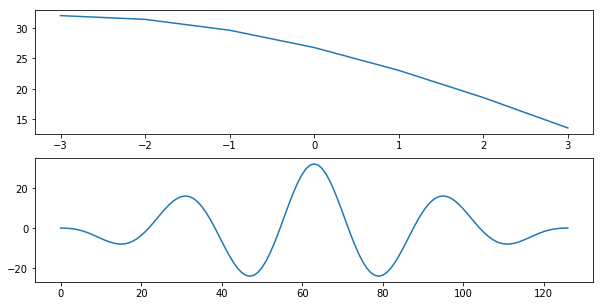

0
[0]
(64,)
(64,)
[ 2.16840434e-18  1.95090322e-01  3.82683432e-01  5.55570233e-01
  7.07106781e-01  8.31469612e-01  9.23879533e-01  9.80785280e-01
  1.00000000e+00  9.80785280e-01  9.23879533e-01  8.31469612e-01
  7.07106781e-01  5.55570233e-01  3.82683432e-01  1.95090322e-01
  1.24633084e-16 -1.95090322e-01 -3.82683432e-01 -5.55570233e-01
 -7.07106781e-01 -8.31469612e-01 -9.23879533e-01 -9.80785280e-01
 -1.00000000e+00 -9.80785280e-01 -9.23879533e-01 -8.31469612e-01
 -7.07106781e-01 -5.55570233e-01 -3.82683432e-01 -1.95090322e-01
 -2.42760955e-16  1.95090322e-01  3.82683432e-01  5.55570233e-01
  7.07106781e-01  8.31469612e-01  9.23879533e-01  9.80785280e-01
  1.00000000e+00  9.80785280e-01  9.23879533e-01  8.31469612e-01
  7.07106781e-01  5.55570233e-01  3.82683432e-01  1.95090322e-01
  3.69562444e-16 -1.95090322e-01 -3.82683432e-01 -5.55570233e-01
 -7.07106781e-01 -8.31469612e-01 -9.23879533e-01 -9.80785280e-01
 -1.00000000e+00 -9.80785280e-01 -9.23879533e-01 -8.31469612e-01
 -7.071

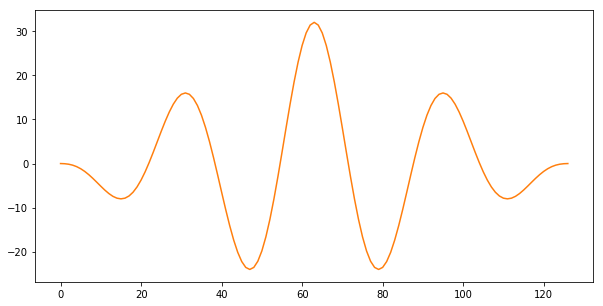

In [4]:
plt.figure(figsize=((10,5)))

plt.subplot(2,1,1)
plt.plot(*auto_covar_for_tau(x,x,3))

plt.subplot(2,1,2)
plt.plot(np.correlate(x, x, 'full'))
plt.show()

plt.figure(figsize=((10,5)))
plt.plot(*auto_corr_for_tau(x, normed=False))
plt.plot(np.correlate(x, x, 'full'))
plt.show()

In [5]:
print(corr(np.array([1,2,3]), np.array([-1, -2, -3]), 2))

[-2.  0.  0.]


In [7]:
def covar(syg_1, syg_2, tau=0):
    
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    syg_1 = syg_1 - np.mean(syg_1)
    syg_2 = syg_2 - np.mean(syg_2)
    
    N = len(syg_1)

    _syg_2 = np.zeros(3*N-2, dtype = 'float')
    _syg_2[N-1:2*N-1] = np.copy(syg_2)

    _syg_1 = np.zeros(3*N-2, dtype= 'float')
    _syg_1[N+(tau-1):2*N + (tau-1)] = np.copy(syg_1)
    
    return np.dot(_syg_1, _syg_2) / (N-1)

def auto_corr_for_tau(syg, normed=False):
    
    tau = np.arange(-len(syg)+1, len(syg))
    f_corr = np.zeros(len(tau))
#     norm = covar(syg, syg)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg, syg, t)

    if normed:
        f_corr /= norm

    return tau, f_corr

def auto_covar(syg_1, syg_2, normed=False):
    tau = np.arange(-len(syg_1)+1, len(syg_1))
    f_corr = np.zeros(len(tau))

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg_1, syg_2, t)

    return tau, f_corr


# Read Signal

In [8]:
from obci_readmanager.signal_processing.read_manager import ReadManager
from pprint import pprint
def read_signals(filename, channels):
    TMSI_OFFSET = 0.0715

    # Initialize the ReadManager
    mgr = ReadManager(filename + ".xml", filename + ".raw", filename + ".tag")
    
    signals = mgr.get_channels_samples(channels) * TMSI_OFFSET
    return signals

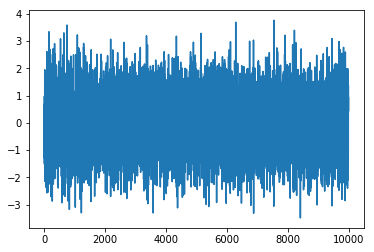

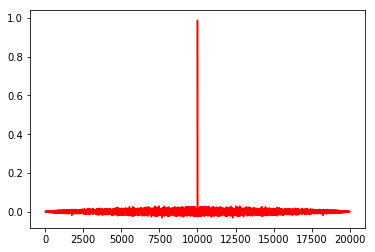

In [9]:
np.random.seed(10000)
x = np.random.normal(size=10000).astype('float')
plt.plot(x)
plt.show()

plt.plot(auto_corr_for_tau(x, normed=False)[1], color='red')
# plt.plot(np.correlate(x, x, 'full'))
plt.show()

In [10]:
o1 = read_signals('../../../data/cw1_otwarte', ['O1'])

2018-10-23 10:27:58,023 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-23 10:27:58,024 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [11]:
o2 = read_signals('../../../data/cw1_zamkniete', ['O1'])

2018-10-23 10:28:19,275 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-23 10:28:19,276 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [12]:
def filter_signal(signal):
    b_highpass, a_highpass = ss.butter(2, 1 / 1024/2, 'highpass')
    b_lowpass, a_lowpass = ss.butter(4, 40 / 1024/2, 'low')
    b_notch, a_notch = ss.iirnotch(50 / 1024/2, 30)
    filt = np.copy(signal)
    filt = ss.filtfilt(b_notch, a_notch, filt)
    filt = ss.filtfilt(b_highpass, a_highpass, filt)
    filt = ss.filtfilt(b_lowpass, a_lowpass, filt)
    return filt

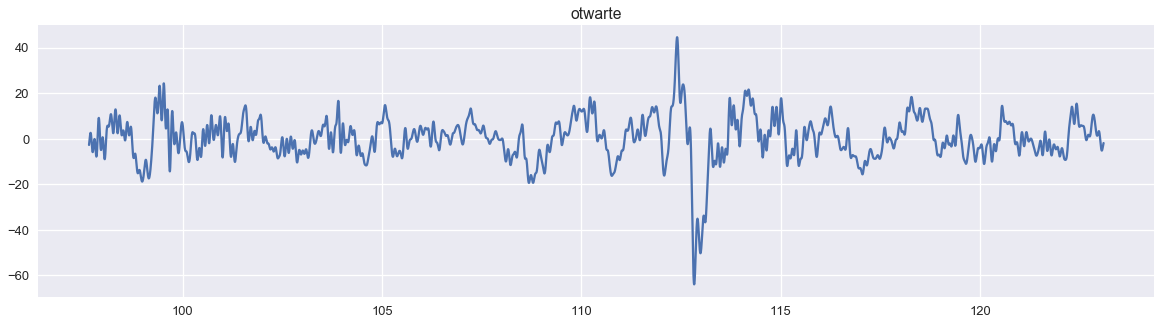

In [16]:
t = np.arange(0, len(o1)) / 1024
filt_o1 = filter_signal(o1)[100000:-500000]

plt.figure(figsize=(20, 5))
plt.plot(t[100000:-500000], filt_o1)
plt.title('otwarte')
plt.show()

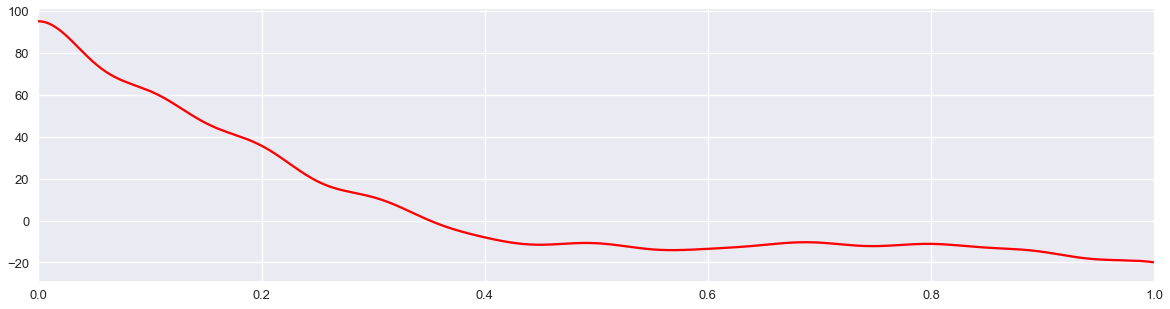

In [17]:
plt.figure(figsize=(20,5))
t, corr = auto_corr_for_tau(filt_o1, normed=False)
plt.plot(t/1024, corr, color='red')
plt.xlim(0,1)
plt.show()

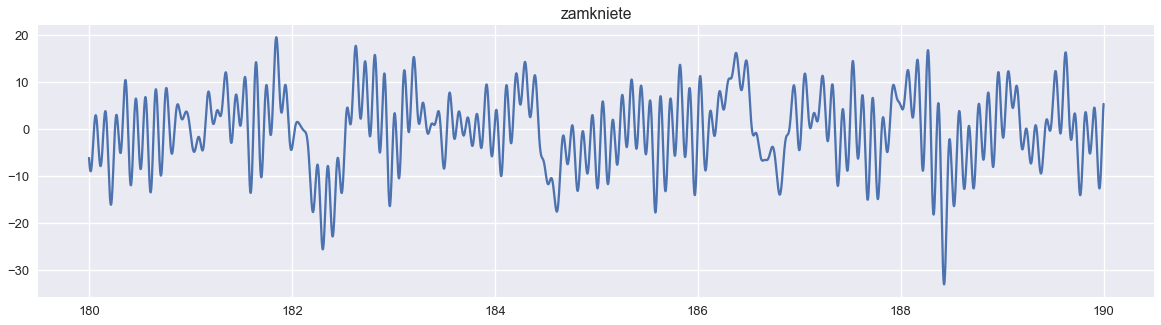

In [18]:
t = np.arange(0, len(o2)) / 1024

start = 3 * 60 * 1024

filt_o2 = filter_signal(o2)[start:start + 1024*10]

plt.figure(figsize=(20, 5))
plt.plot(t[start:start + 1024*10], filt_o2)
plt.title('zamkniete')
plt.show()

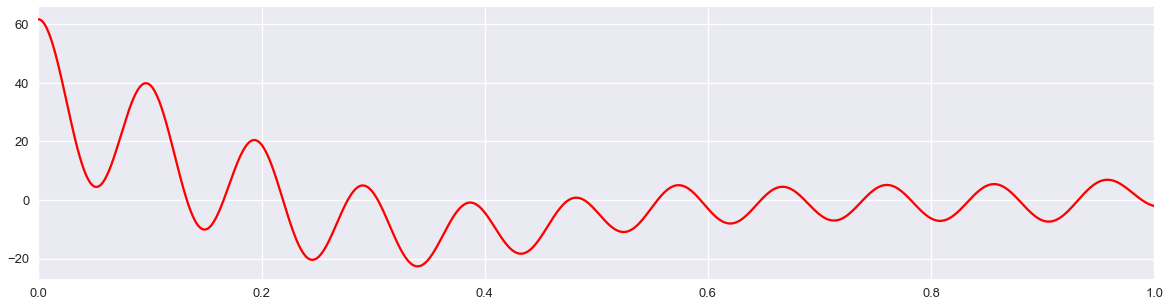

In [19]:
plt.figure(figsize=(20,5))
t, corr = auto_corr_for_tau(filt_o2, normed=False)
plt.plot(t/1024, corr, color='red')
plt.xlim(0,1)
plt.show()

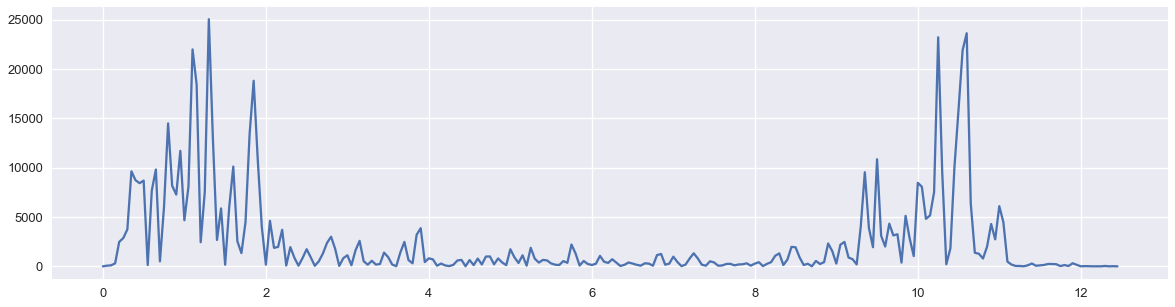

In [20]:
plt.figure(figsize=(20,5))
plt.plot(np.fft.rfftfreq(len(corr), 1/1024)[:250], abs(np.fft.rfft(corr)[:250]))
plt.show()

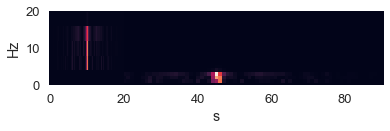

In [21]:
f, t, s = ss.spectrogram(corr, 1024)
plt.pcolormesh(t, f, s)
plt.imshow(s)
plt.ylabel('Hz')
plt.xlabel('s')
plt.ylim(0,20)
plt.show()

In [22]:
F, P = ss.welch(filt_o2, 1024, window='hanning')

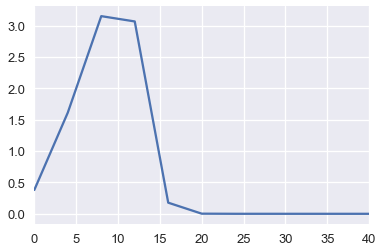

In [23]:
plt.plot(F,P)
plt.xlim(0,40)
plt.show()

# Zadanie 3

In [24]:
channels = ['Fp1', 'Fp2', 'P3', 'Pz', 'P4', 'O1', 'O2']
signals_closed = read_signals('../../../data/cw1_zamkniete', channels)

2018-10-23 10:29:30,388 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-23 10:29:30,389 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [25]:
Fs = 1024
nyq = Fs/2
t = np.arange(0, signals_closed.shape[1]) / Fs
start = int(1.5 * 60 * Fs)
end = int(start + 1 * Fs)

In [26]:
filtered_closed = filter_signal(signals_closed)

 6 6 49


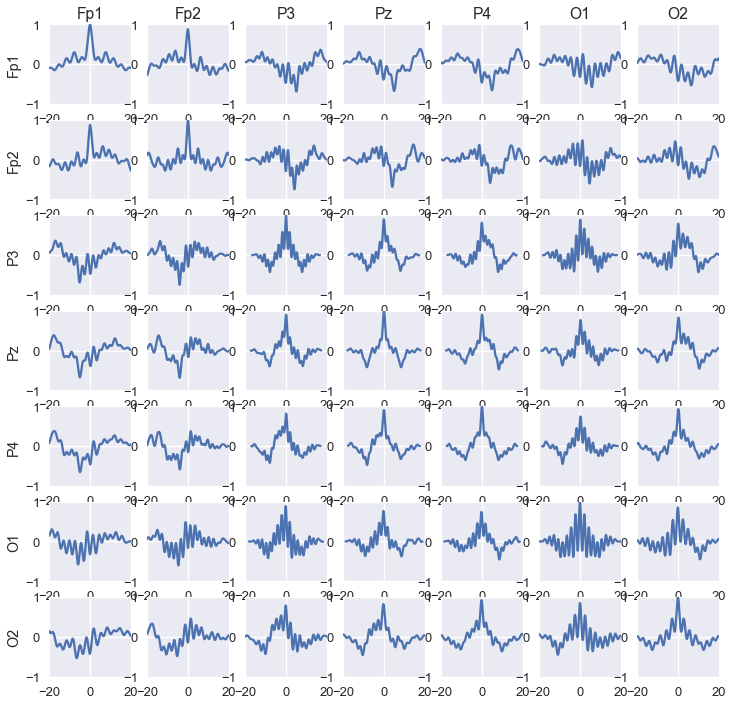

In [27]:
import sys
plt.figure(figsize=(12,12))

for i, x in enumerate(filtered_closed):
    for j, y in enumerate(filtered_closed):
        sys.stdout.write('\r {} {} {}'.format(i, j, (j+1) + (i*filtered_closed.shape[0])))
        
        
        plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (j+1) + (i*filtered_closed.shape[0]))
        
        if j == 0:
            plt.ylabel(channels[i])
        if not i:
            plt.title(channels[j])
        t, cov = auto_covar(x[start: end], y[start: end], normed=False) / (np.std(x[start: end]) * np.std(y[start: end]))

        plt.plot(t, cov)
        plt.ylim(-1,1)
        plt.xlim(-20, 20)

sys.stdout.write('\r\n')
plt.show()

In [28]:
def covar(syg_1, syg_2, tau=0):
    
    if syg_1.shape != syg_2.shape:
        raise ValueError("Can't compare size %d with %d"%(syg_1.shape, syg_2.shape))
    
    syg_1 = syg_1 - np.mean(syg_1)
    syg_2 = syg_2 - np.mean(syg_2)
    
    N = len(syg_1)

    _syg_2 = np.zeros(3*N-2, dtype = 'float')
    _syg_2[N-1:2*N-1] = np.copy(syg_2)

    _syg_1 = np.zeros(3*N-2, dtype= 'float')
    _syg_1[N+(tau-1):2*N + (tau-1)] = np.copy(syg_1)
    
    return np.dot(_syg_1, _syg_2) / (N-1)

def auto_corr_for_tau(syg, normed=False):
    
    tau = np.arange(-len(syg)+1, len(syg))
    f_corr = np.zeros(len(tau))
#     norm = covar(syg, syg)

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg, syg, t)

    if normed:
        f_corr /= norm

    return tau, f_corr

def auto_covar(syg_1, syg_2, normed=False):
    tau = np.arange(-len(syg_1)+1, len(syg_1))
    f_corr = np.zeros(len(tau))

    for index, t in enumerate(tau):
        f_corr[index] = covar(syg_1, syg_2, t)

    return tau, f_corr

# 

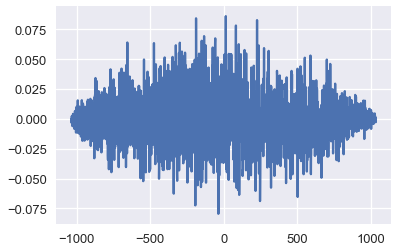

In [29]:
x = np.random.normal(size=1024)
y = np.random.normal(size=1024)
t, corr = auto_covar(x, y) / (np.std(x) * np.std(y))

plt.plot(t, corr)

 999

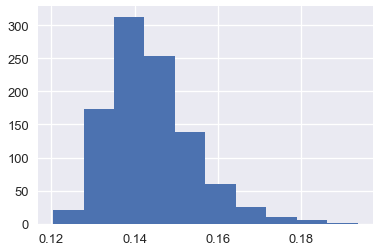

In [31]:
import itertools

max_covs = []


_filtered_closed = np.array(list(map(lambda x: filtered_closed[x, start: end] - np.mean(filtered_closed[x]), range(len(filtered_closed)))))


combinations = list(itertools.combinations(_filtered_closed , 2))

all_covs = np.array([])

for k in range(1000):
    sys.stdout.write('\r {}'.format(k))
    max_partial_covs = []
    
    for combination in combinations:
            
            x = combination[0]
            y = combination[1]
            
#             print(x)
            
            np.random.shuffle(x)
            np.random.shuffle(y)

            norm = np.std(x) * np.std(y)
            
            cov = np.correlate(x, y, 'full') / (len(x) - 1)
            
#             all_covs = np.concatenate((all_covs, cov))
            
            max_partial_covs.append(max(cov) / norm)
          
    max_covs.append(max(max_partial_covs))

plt.hist(max_covs)
plt.show()

# plt.hist(all_covs)
# plt.show()

In [32]:
import scipy.stats as st

print(st.scoreatpercentile(max_covs, 99.5))
print(st.scoreatpercentile(max_covs, 0.5))

0.17998064436516129
0.12482843709407401


 6 6 49


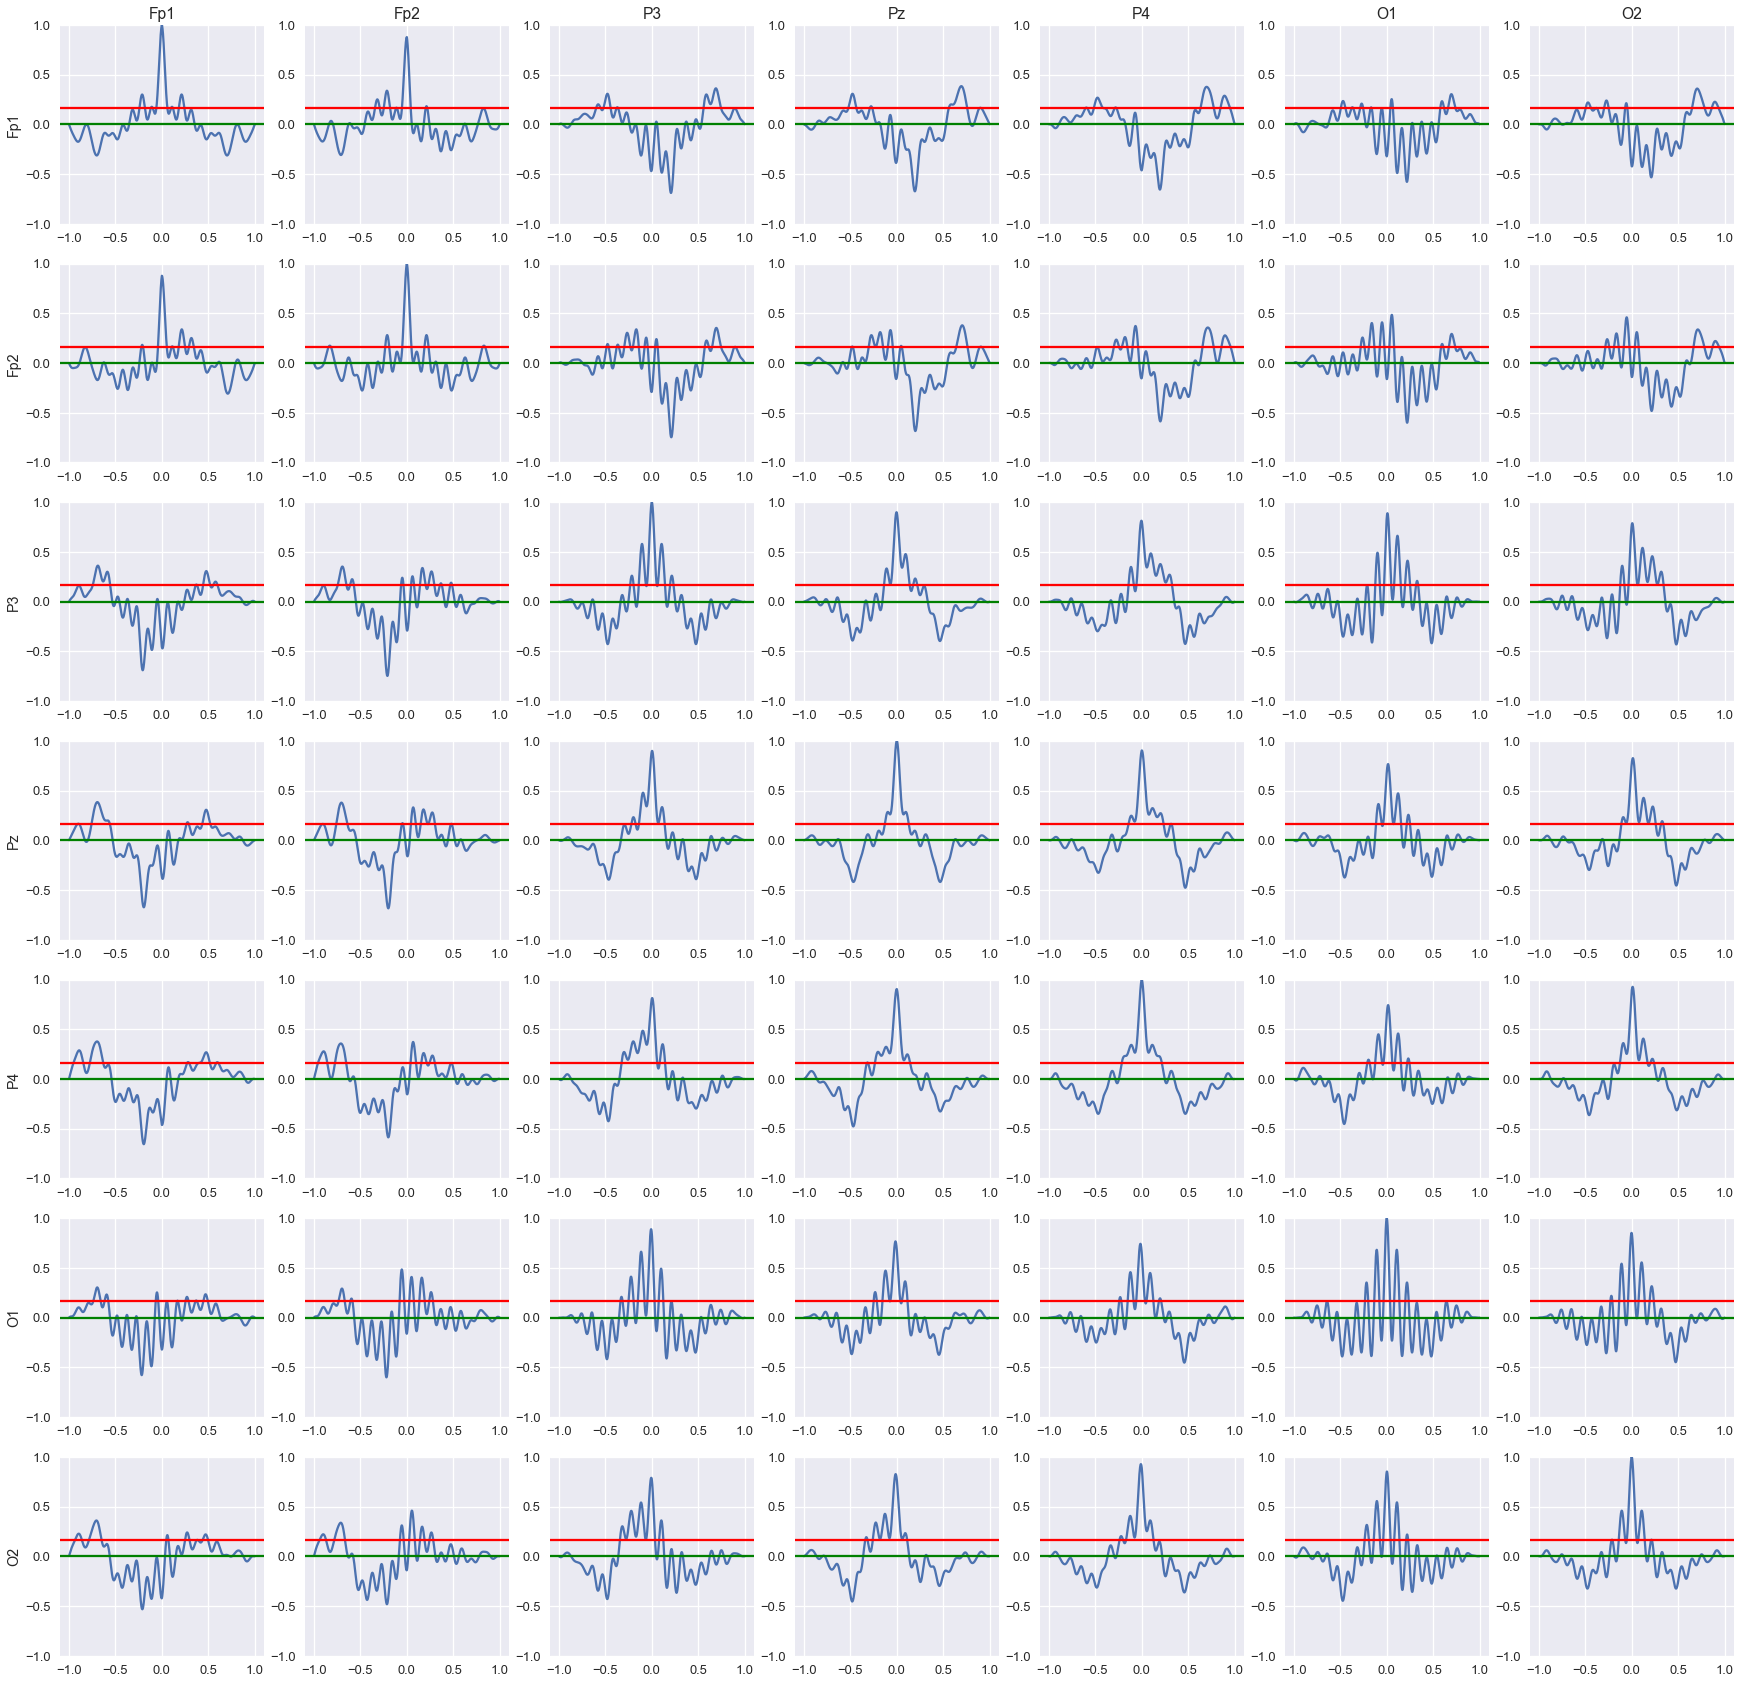

In [33]:
import sys
plt.figure(figsize=(30,30))

high_perc = st.scoreatpercentile(max_covs, 95)

for i, x in enumerate(filtered_closed):
    for j, y in enumerate(filtered_closed):
        sys.stdout.write('\r {} {} {}'.format(i, j, (j+1) + (i*filtered_closed.shape[0])))
        
        plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (j+1) + (i*filtered_closed.shape[0]))
        
        if j == 0:
            plt.ylabel(channels[i])
        if not i:
            plt.title(channels[j])
        t, cov = auto_covar(x[start: end], y[start: end], normed=False)
        cov /= (np.std(x[start: end]) * np.std(y[start: end]))
        t = t / Fs
        plt.plot(t, cov)
        plt.axhline(high_perc, c='r')
        plt.axhline(0, c='g')
        
        plt.ylim(-1,1)

sys.stdout.write('\r\n')
plt.show()

# Zadanie 4

a)

In [37]:
import itertools
from numba import jit
from tqdm import tqdm
import math
import seaborn as sns
sns.set()
sns.set_context('poster')

def func(f, gamma, tau, d_tau=1./1024):
    '''
        f - f requency at which checking
        gamma - covariance of two signals
        tau - index representing time shift
    '''
    return gamma[tau] * np.exp(-2 * np.pi * np.complex(0, 1) * f * tau * d_tau)

@jit
def integral(f, gamma, d_tau=1./1024):
    c = 0
    for tau in range(len(gamma)):
        c += func(f, gamma, tau, d_tau) * d_tau
    
    return c

@jit
def spectrum(gamma, Fs=1024, low=0, high=512):
    f_max = high + 1
    F = np.empty(f_max - low)
    F_freq = np.arange(f_max - low)
    
    for index, f in enumerate(F_freq):
        F[index] = integral(f, gamma, 1./Fs)
    
    return F_freq, F

def co_spectrum(x, y, low=0, high=512):

            norm = np.std(x) * np.std(y)

            cov = np.correlate(x, y, 'full') / (len(x) - 1)
            
            cov /= norm

            F_freq, F = spectrum(cov, low=low, high=high)
            
            return F_freq, abs(F), np.unwrap(np.angle(F)) / (2 * np.pi * F_freq)

            
def plot_spectrum():
    _filtered_closed = np.array(list(map(lambda x: filtered_closed[x, start: end] - np.mean(filtered_closed[x]), range(len(filtered_closed)))))

    combinations = list(itertools.combinations_with_replacement(range(filtered_closed.shape[0]) , 2))

    plt.figure(figsize=(25,25))
    plt.tight_layout()

    for combination in tqdm(combinations):

        i = combination[0]
        j = combination[1]

        x = _filtered_closed[i]
        y = _filtered_closed[j]
        F_freq, F, _ = co_spectrum(x, y, high=20)

        plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (j+1) + (i*filtered_closed.shape[0]))

        xticks = []
        yticks = []

        if not i:
            plt.title(channels[j])
            xticks = plt.xticks()[0]
            yticks = plt.yticks()[0]

        if j == 0 and i == 0:
            plt.ylabel(channels[i])
            xticks = plt.xticks()[0]



        plt.plot(F_freq, F)
        plt.ylim(0, 0.3)
        plt.xticks(np.arange(0, 30, 10))

        plt.grid()

        if j != i:
            plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (i+1) + (j*filtered_closed.shape[0]))

            yticks = []

            if not i:
                plt.ylabel(channels[j])
                yticks = plt.yticks()[0]
            plt.plot(F_freq, F)
            plt.ylim(0, 0.3)
            plt.xticks(np.arange(0, 30, 10))
            plt.grid()
    plt.show()
    
def plot_phase():
    _filtered_closed = np.array(list(map(lambda x: filtered_closed[x, start: end] - np.mean(filtered_closed[x]), range(len(filtered_closed)))))

    combinations = list(itertools.combinations_with_replacement(range(filtered_closed.shape[0]) , 2))

    plt.figure(figsize=(25,25))
    plt.tight_layout()

    for combination in tqdm(combinations):

        i = combination[0]
        j = combination[1]

        x = _filtered_closed[i]
        y = _filtered_closed[j]
        F_freq, _, phase = co_spectrum(x, y, high=20)

        plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (j+1) + (i*filtered_closed.shape[0]))

        xticks = []
        yticks = []

        if not i:
            plt.title(channels[j])
            xticks = plt.xticks()[0]
            yticks = plt.yticks()[0]

        if j == 0 and i == 0:
            plt.ylabel(channels[i])
            xticks = plt.xticks()[0]



        plt.plot(F_freq, phase)
        
        plt.xticks(np.arange(0, 30, 10))

        plt.grid()

        if j != i:
            plt.subplot(filtered_closed.shape[0], filtered_closed.shape[0], (i+1) + (j*filtered_closed.shape[0]))

            yticks = []

            if not i:
                plt.ylabel(channels[j])
                yticks = plt.yticks()[0]
            plt.plot(F_freq, -phase)
            
            plt.xticks(np.arange(0, 30, 10))
            plt.grid()

    plt.show()


  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 28/28 [00:13<00:00,  2.39it/s]


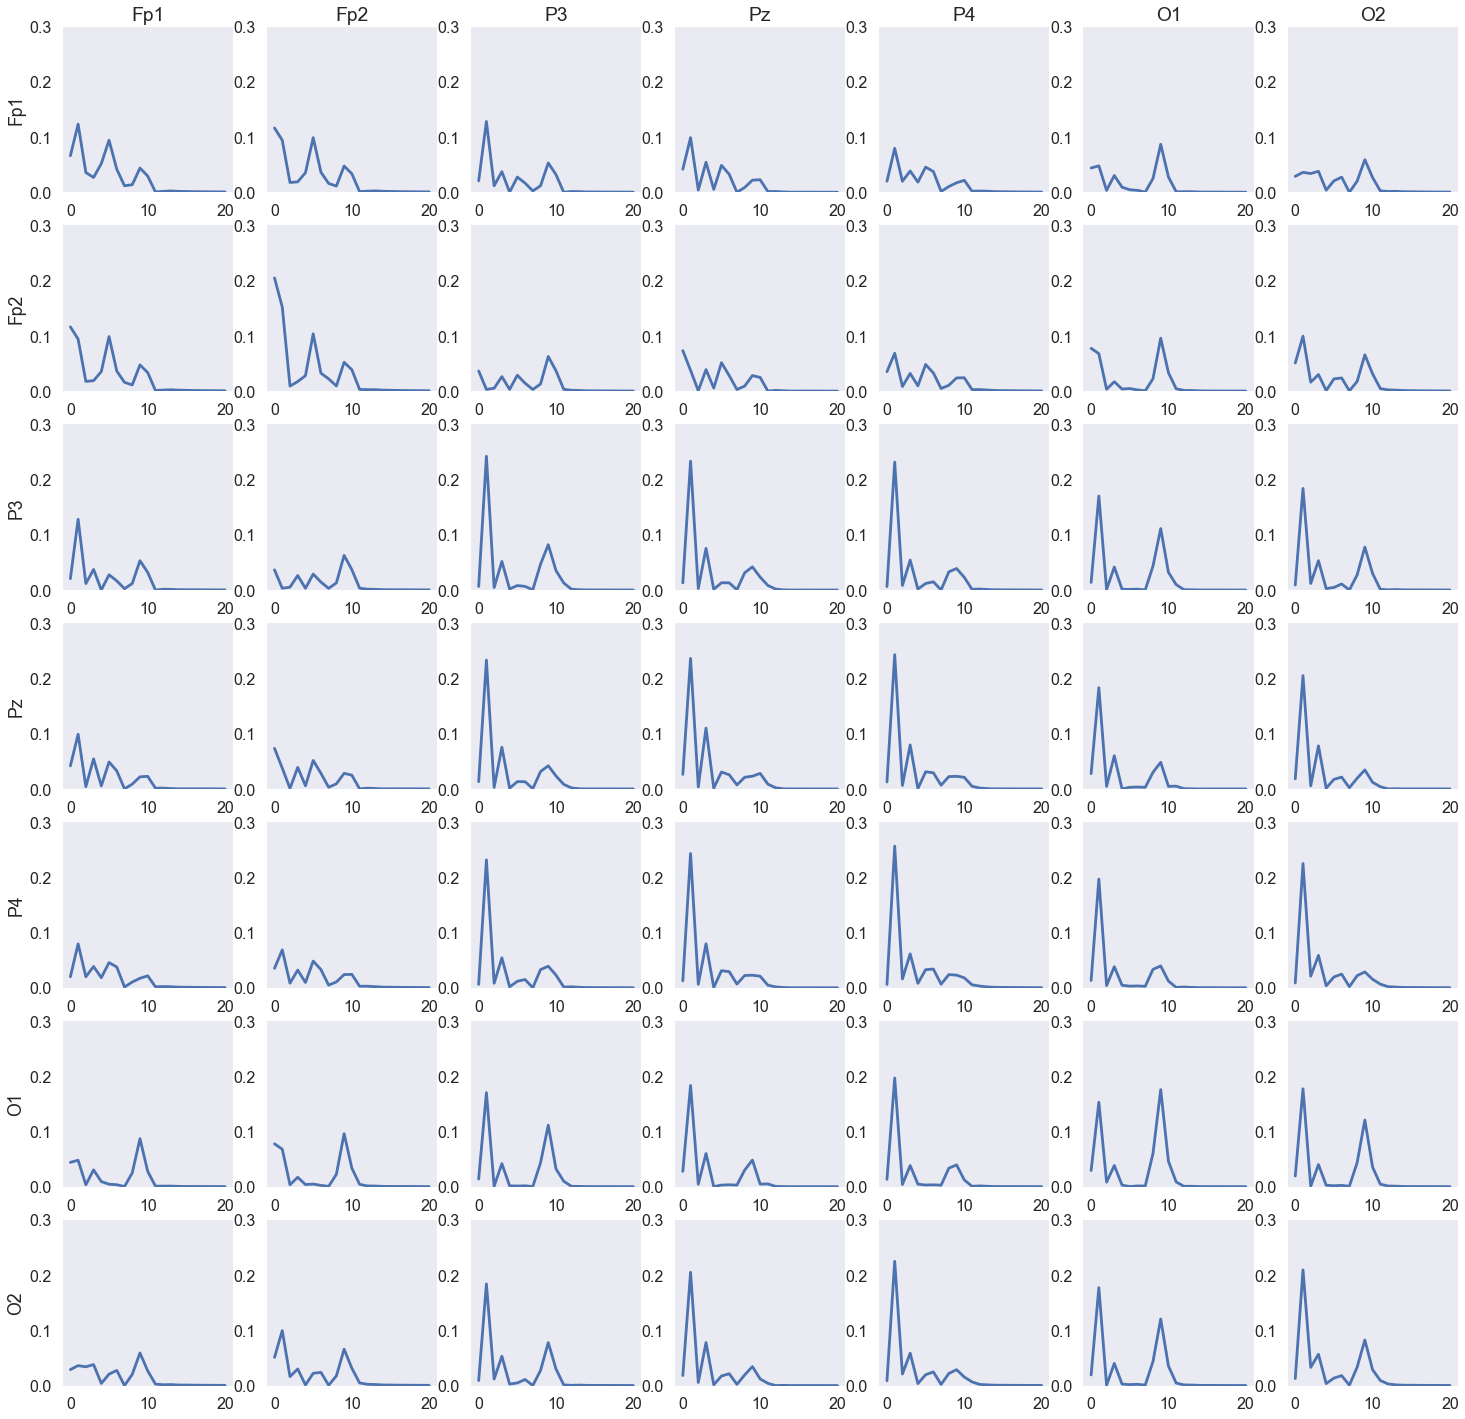

In [35]:
plot_spectrum()

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 28/28 [00:12<00:00,  2.39it/s]


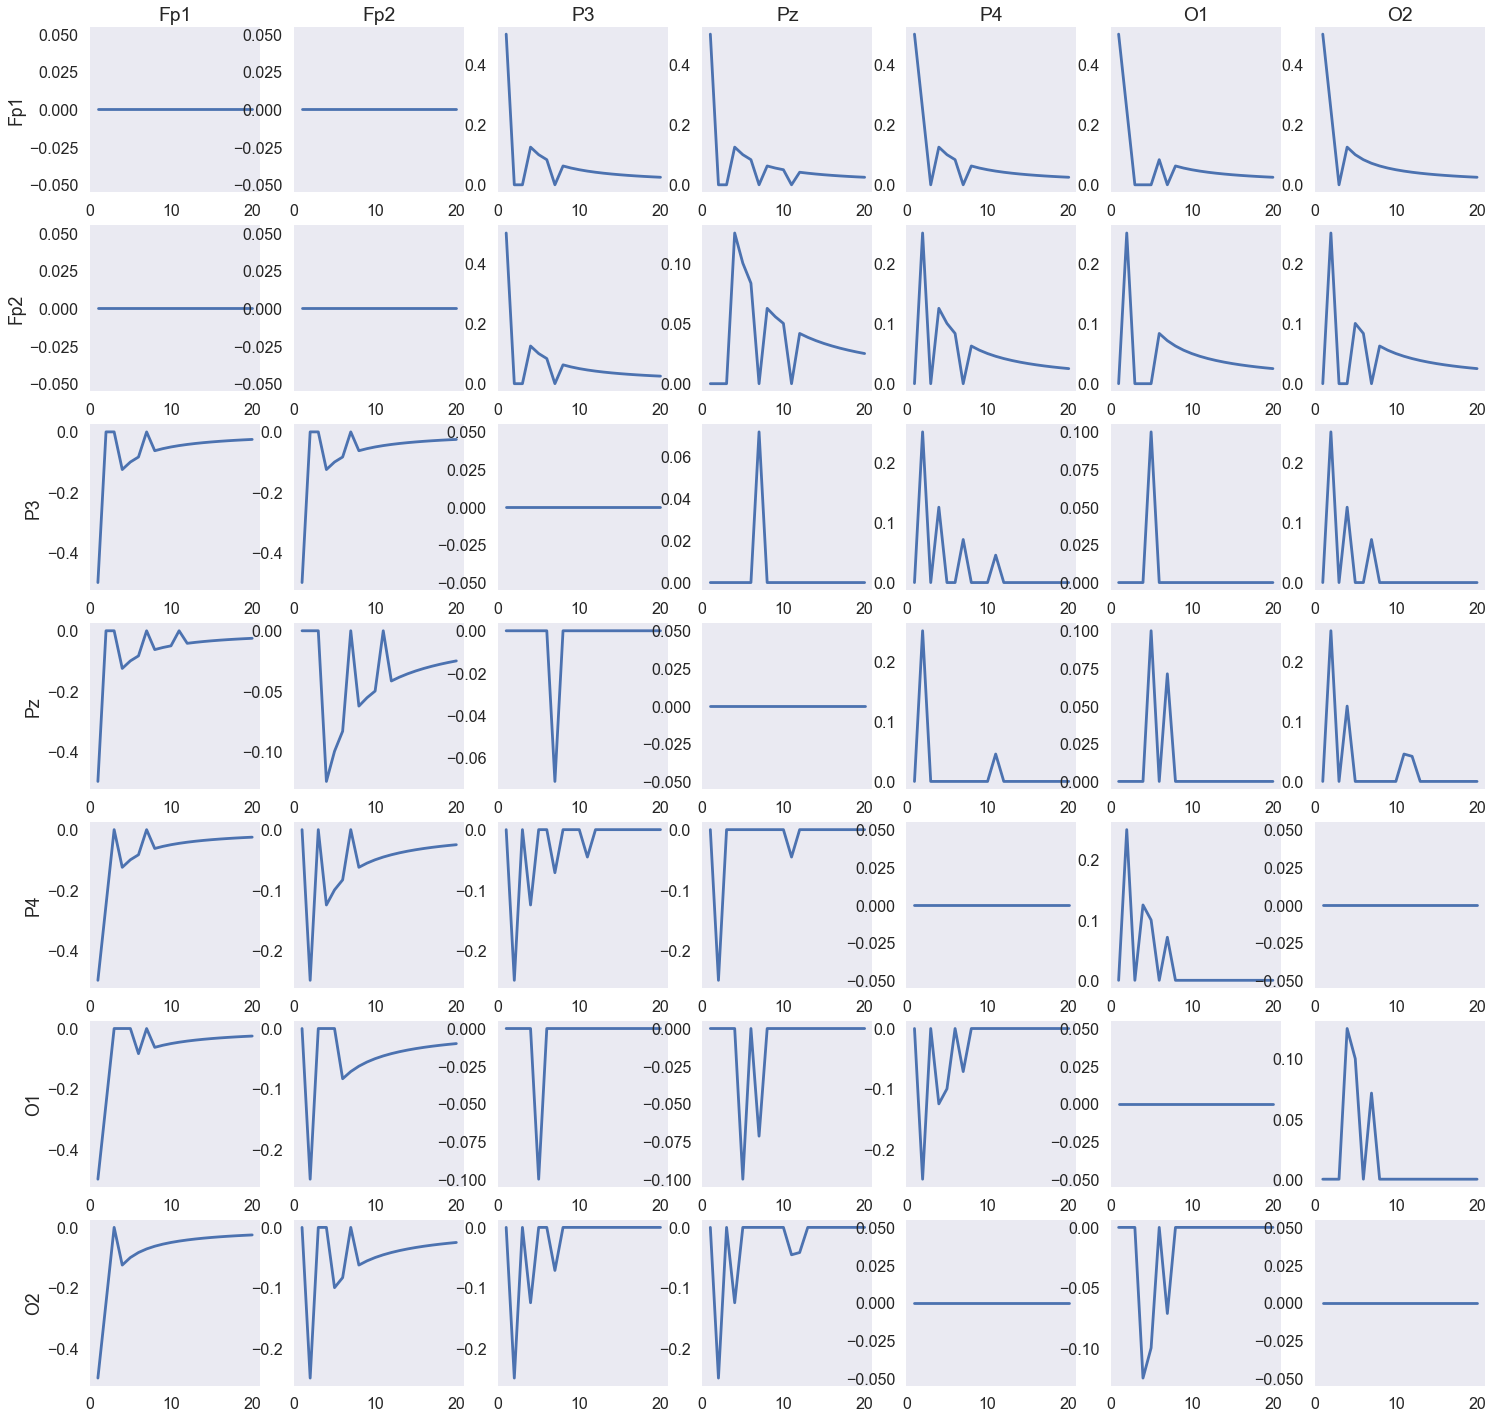

In [38]:
plot_phase()